In [42]:
dataset_folder = '/mnt/Data1/Nick/transcription_pipeline/'

embryo_list = [
    'test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo01',
    'test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo02',
    'test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Var2(001)_embryo20',
    'test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Var2(001)_embryo38',
]

test_dataset_name = dataset_folder + embryo_list[0]
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo01


Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo01
Load previous particle trace fit checking results from "particle_fits_checked.pkl"


<Figure size 640x480 with 0 Axes>

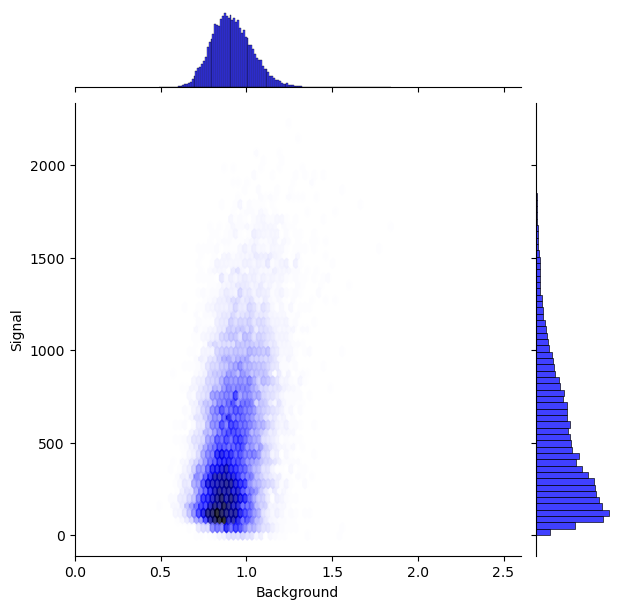

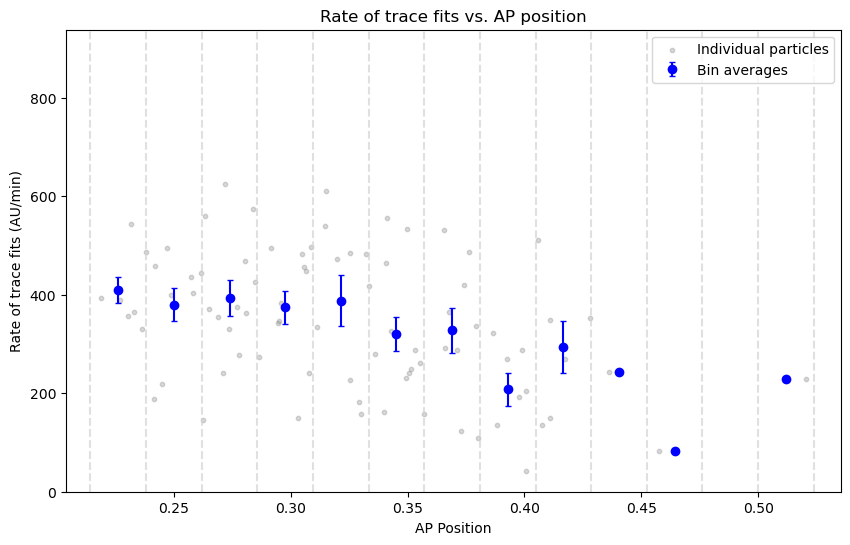

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Var2(001)_embryo02
Load previous particle trace fit checking results from "particle_fits_checked.pkl"


<Figure size 640x480 with 0 Axes>

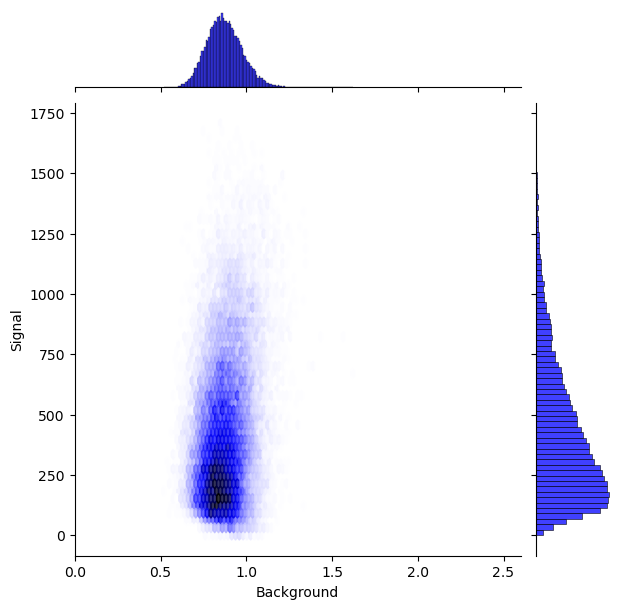

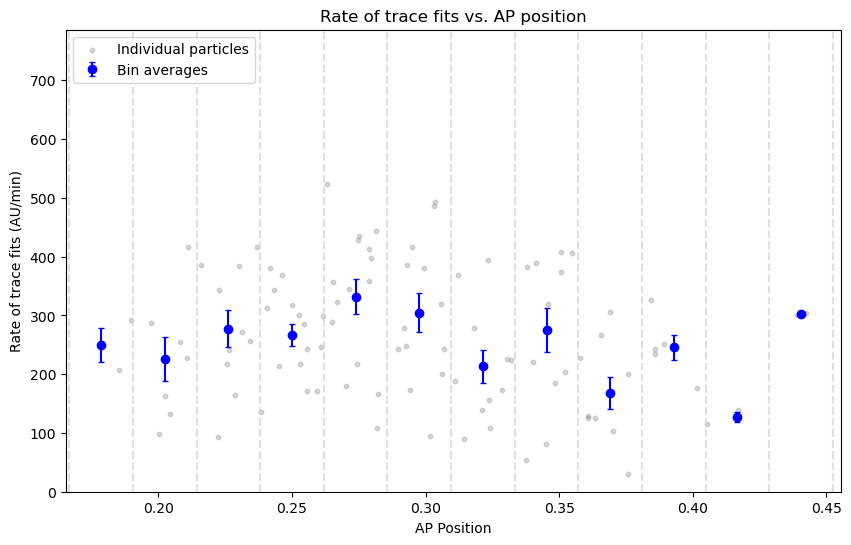

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Var2(001)_embryo20
Load previous particle trace fit checking results from "particle_fits_checked.pkl"


<Figure size 640x480 with 0 Axes>

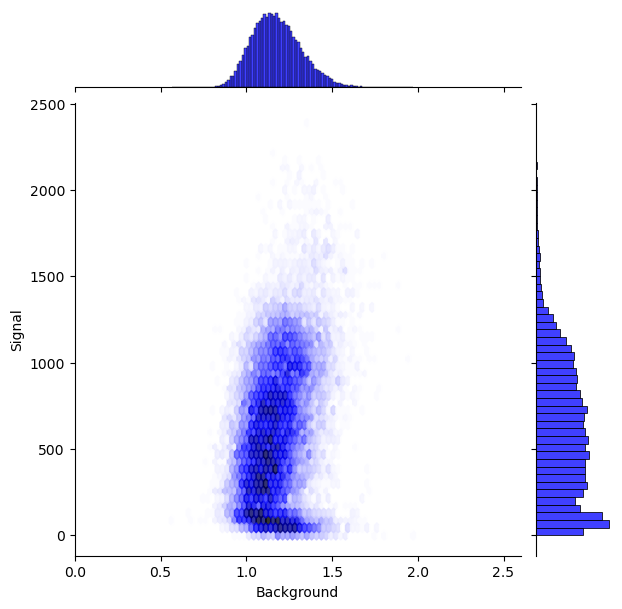

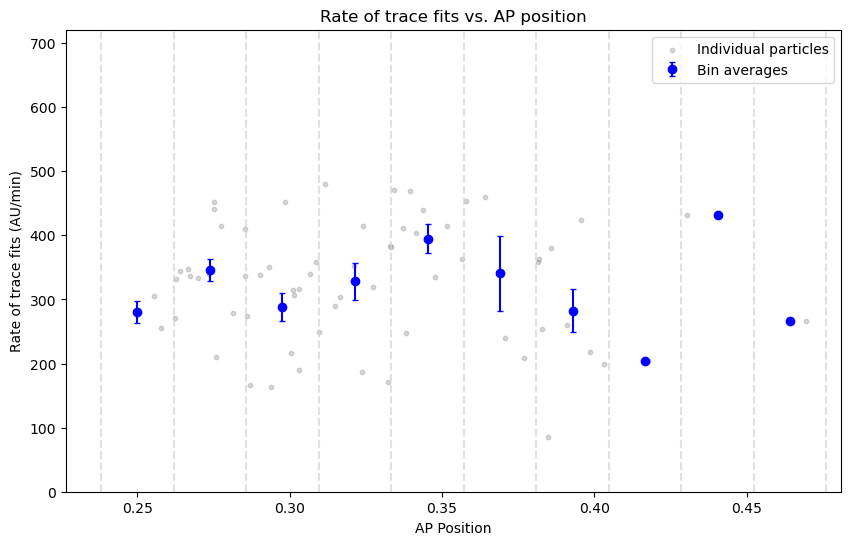

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Var2(001)_embryo38
Load previous particle trace fit checking results from "particle_fits_checked.pkl"


<Figure size 640x480 with 0 Axes>

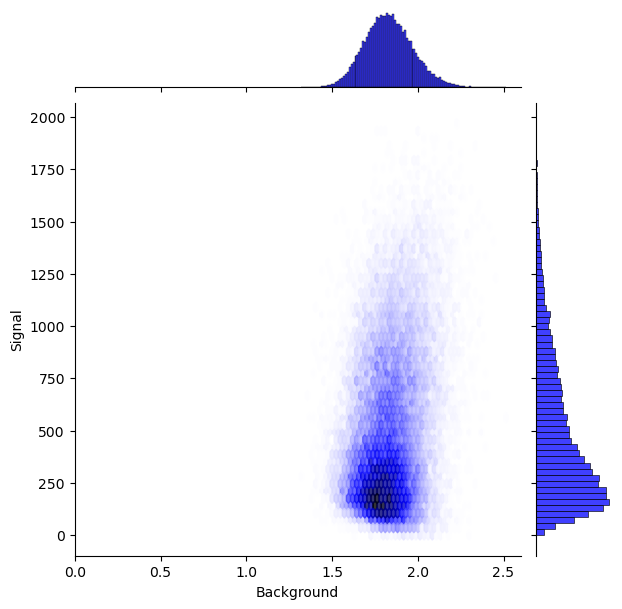

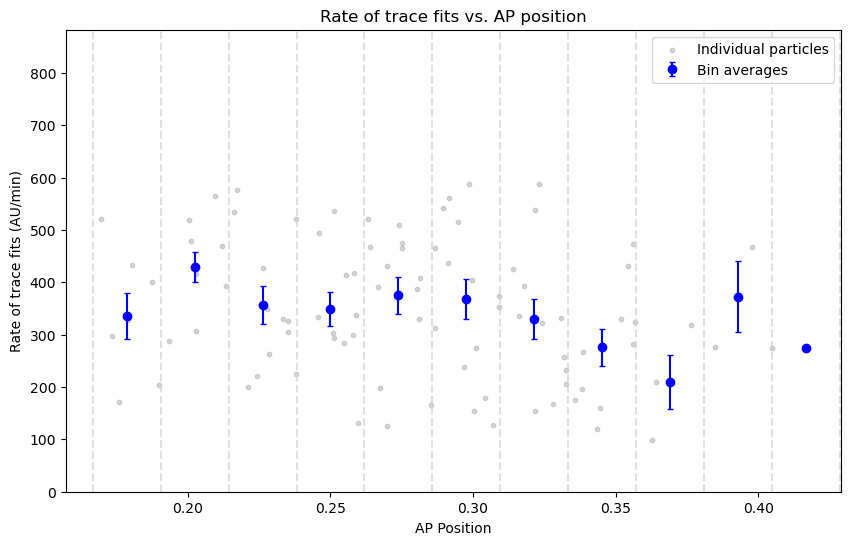

In [57]:
from transcription_pipeline.RateExtraction import FitAndAverage
from transcription_pipeline import spot_pipeline
from transcription_pipeline import nuclear_pipeline
# from sklearn.metrics import r2_score  # Still useful
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns

# Specify here at what frame NC14 starts
nc14_start_frame = 0

# Any trace with frame number smaller than min_frames will be filtered out
min_frames = 40

# Number of bins you want to split the full embryo into
num_bins = 42

# List to hold result rows
results = []

# Loop over embryos
for i in range(len(embryo_list)):
    # Define the dataset path
    test_dataset_name = dataset_folder + embryo_list[i]
    print('Dataset Path: ' + test_dataset_name)

    ### Signal vs. Background Analysis
    spot_tracking = spot_pipeline.Spot()
    spot_tracking.read_results(name_folder=test_dataset_name)

    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)

    spot_df = spot_tracking.spot_dataframe
    detected_spots = spot_df[spot_df["particle"] != 0]

    signal = np.array(detected_spots['intensity_from_neighborhood'])
    background = np.array(detected_spots['background_intensity_from_neighborhood'])

    nuclear_df = nuclear_tracking.mitosis_dataframe
    nuclear_df = nuclear_df.sort_values(by='frame')
    avg_nuclear_intensity = nuclear_df['nuclear_intensity_mean'].to_numpy()

    # Plot signal vs background
    plt.figure()
    sns.jointplot(x=background, y=signal, kind='hex', color='blue', alpha=0.8)
    plt.xlim(left=0, right=2.6)
    plt.xlabel('Background')
    plt.ylabel('Signal')
    # plt.title('Signal vs Background for \n' + test_dataset_name)

    ### Slope Analysis
    dataframe_path = test_dataset_name + '/compiled_dataframe.pkl'
    compiled_dataframe = pd.read_pickle(dataframe_path)

    fit_and_average = FitAndAverage(compiled_dataframe, nc14_start_frame, min_frames, num_bins, test_dataset_name)
    x, y, y_err, _, _ = fit_and_average.average_particle_fits()

    results.append({
        'embryo_id': embryo_list[i],
        'avg_bkg': np.mean(background),
        'avg_signal': np.mean(signal),
        'avg_nuclear_intensity': avg_nuclear_intensity,
        'x': x,
        'y': y,
        'y_err': y_err
    })

# Convert results to DataFrame
average_fit_df = pd.DataFrame(results)


In [44]:
average_fit_df

,embryo_id,avg_bkg,avg_signal,avg_nuclear_intensity,x,y,y_err
0,test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Va...,0.919542,482.349871,"[0.6840796019900498, 0.895221238938053, 0.8873...","[0.011904761904761904, 0.03571428571428571, 0....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,test_data/NSPARC/2025-03-31/MCP-mSG_His-RFP_Va...,0.873166,411.853777,"[0.768646408839779, 0.9455, 0.895427795382526,...","[0.011904761904761904, 0.03571428571428571, 0....","[nan, nan, nan, nan, nan, nan, nan, 249.624231...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 29.5137523..."
2,test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Va...,1.178332,605.343142,"[0.07050847457627119, 0.07987220447284345, 0.0...","[0.011904761904761904, 0.03571428571428571, 0....","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,test_data/NSPARC/2025-04-01/MCP-mSG_His-RFP_Va...,1.831660,478.098847,"[0.5673327541268463, 0.5047114252061249, 0.415...","[0.011904761904761904, 0.03571428571428571, 0....","[nan, nan, nan, nan, nan, nan, nan, 336.615644...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 43.9158159..."


/tmp/ipykernel_516813/92707495.py:33: RuntimeWarning: Mean of empty slice
  avg_rates = [np.nanmean(bin_dict[bin]) for bin in avg_bins]
/mnt/Data1/Nick/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


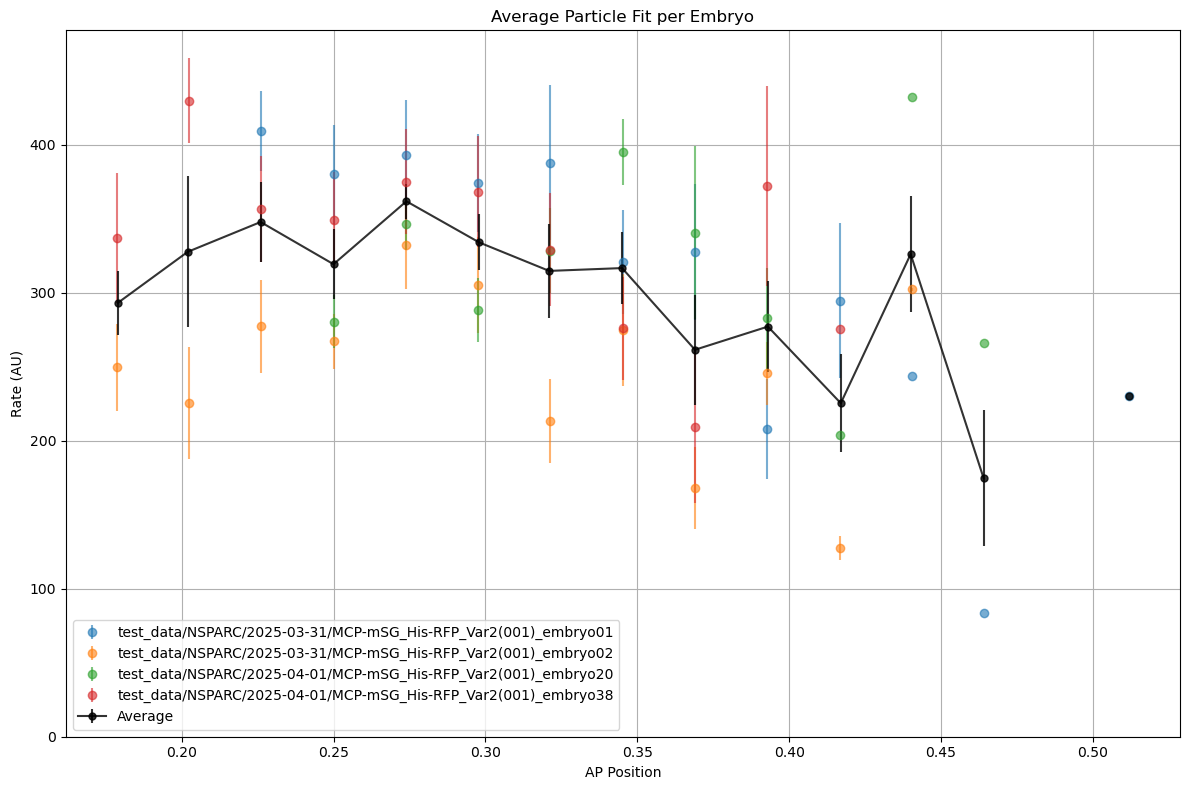

In [28]:

import pandas as pd

plt.figure(figsize=(12, 8))

# Store all embryo curves
all_x = []
all_y = []

# Plot each embryo's data
for i in range(len(average_fit_df)):
    x = np.array(average_fit_df['x'][i])
    y = np.array(average_fit_df['y'][i])
    y_err = np.array(average_fit_df['y_err'][i])

    plt.errorbar(x, y, yerr=y_err, label=average_fit_df['embryo_id'][i], fmt='o', alpha=0.6)

    all_x.append(x)
    all_y.append(y)

# Combine all data into a dictionary of bin -> list of values
bin_dict = {}
for x_vals, y_vals in zip(all_x, all_y):
    for xi, yi in zip(x_vals, y_vals):
        xi_rounded = np.round(xi, 3)  # Round to avoid float mismatch
        if xi_rounded not in bin_dict:
            bin_dict[xi_rounded] = []
        bin_dict[xi_rounded].append(yi)

# Compute mean per bin
avg_bins = sorted(bin_dict.keys())
avg_rates = [np.nanmean(bin_dict[bin]) for bin in avg_bins]
# Compute standard error per bin using error propagation
avg_errors = [np.nanstd(bin_dict[bin]) / np.sqrt(len(bin_dict[bin])) for bin in avg_bins]

# Plot the average line
plt.errorbar(avg_bins, avg_rates, yerr=avg_errors, label='Average',
             fmt='-o', color='black', alpha=0.8, markersize=5)

# Final plot tweaks
plt.xlabel('AP Position')
plt.ylabel('Rate (AU)')
plt.ylim(bottom=0)

plt.title('Average Particle Fit per Embryo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()